# Titanic example using featuresets

In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
import argparse
import yaml
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from dkube.sdk import *

## Getting API client handle

In [2]:
# Dkube user access token for API authentication
authToken = os.getenv("DKUBE_USER_ACCESS_TOKEN")
# Get client handle
api = DkubeApi(token=authToken)

## Creating Featureset into Feature Store

In [3]:
train_fs = generate('train-fs')
print(f"Featureset name {train_fs}\n")
featureset = DkubeFeatureSet(name=train_fs, description="Titanic FeatureSet experiments")
print(f"---- Featureset name {train_fs} -- Create featureset \n")
api.create_featureset(featureset)

Featureset name train-fs-4518

---- Featureset name train-fs-4518 -- Create featureset 

create_featureset: waiting for featureset to be setup
create_featureset: waiting for featureset to be setup
create_featureset: waiting for featureset to be setup
create_featureset: waiting for featureset to be setup
create_featureset: waiting for featureset to be setup


{'code': 200, 'message': 'Successfully created featureSet', 'uuid': None}

## Reading data

In [4]:
train_data = pd.read_csv("https://dkube.s3.amazonaws.com/datasets/titanic/train.csv")
print(train_data.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [5]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Feature Engineering on training data

In [6]:
train_data["Age"].fillna(value=train_data["Age"].median(), inplace=True)

# Drop rows where fare is less than 100
train_data = train_data[train_data["Fare"] < 100]

# Fill in null values
train_data["Embarked"].fillna(method="ffill", inplace=True)

# test_data = pd.read_csv("titanic/test.csv")
# test_data['Age'].fillna(value=test_data['Age'].median(), inplace=True)
# test_data['Fare'].fillna(test_data['Fare'].median() , inplace = True)

# Select features for training
features = ["Pclass", "Sex", "SibSp", "Parch"]
train_df = pd.get_dummies(train_data[features])
train_df = pd.concat([train_data[["Age", "Fare", "Survived"]], train_df], axis=1)
print(train_df.head())

    Age     Fare  Survived  Pclass  SibSp  Parch  Sex_female  Sex_male
0  22.0   7.2500         0       3      1      0           0         1
1  38.0  71.2833         1       1      1      0           1         0
2  26.0   7.9250         1       3      0      0           1         0
3  35.0  53.1000         1       1      1      0           1         0
4  35.0   8.0500         0       3      0      0           0         1


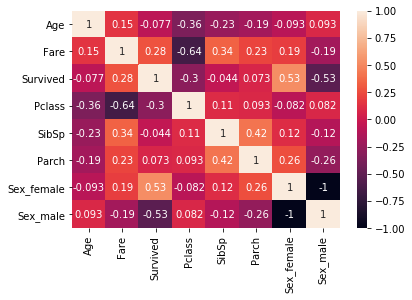

In [7]:
sns.heatmap(train_df.corr(), annot=True)

## Committing features to the generated featureset in Feature Store

In [8]:
resp = api.commit_featureset(name=train_fs, df=train_df)
print(resp)

{'code': 200, 'message': 'Successfully created featureSet version', 'uuid': None}


## Reading featureset from Feature Store

In [9]:
feature_df = api.read_featureset(name=train_fs)

read_featureset: No version specified, using the latest version v2
read_featureset: version v2 not ready, state:data_add_in_progress expected:synced
read_featureset: version v2 not ready, state:data_add_complete expected:synced
read_featureset: version v2 not ready, state:data_push_complete expected:synced
read_featureset: version v2 not ready, state:meta_commit_done expected:synced
read_featureset: features not ready, status:starting expected:completed


## Preparing input output pairs

In [10]:
y = feature_df["Survived"].values
x = feature_df.drop("Survived", 1).values

## Training random forest classifier

In [11]:
model_RFC = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model_RFC.fit(x, y)
predictions = model_RFC.predict(x)

In [12]:
accuracy = accuracy_score(y, predictions)

## Accuracy

In [13]:
accuracy

0.8448687350835322